<div style="display: flex; background-color: RGB(51,78,255);" >
<h2 style="margin: auto; padding: 30px; ">PROJET 10 : Détectez des faux billets avec R ou Python</h2>
</div>

![Lapage](/notebooks/Desktop/ONCFM3.png "ShowMyImage")

### <u>IDENTIFICATION DES BESOINS</u>

ONCFM (Organisation Nationale de lutte Contre le Faux-Monnayage) est une organisation publique ayant pour objectif de mettre en place des méthodes d’identification des contrefaçons des billets en euros.<br>
Elle souhaite mettre en place un algorithme qui soit capable de différencier automatiquement les vrais des faux billets.<br><br>
L'objectif est de :<br>
- Construire un algorithme qui, à partir des caractéristiques géométriques d’un billet, serait capable de définir si ce dernier est un vrai ou un faux billet.
<br><br>
Dans un 1er temps, nous ferons une analyse descriptive des données :<br>
    - Répartitions des dimensions des billets
    - Nombre de vrais/faux billets
    - etc...

<br>Deux méthodes de prédictions vont être mises en concurrence:<br>
    - Une regression Logistique classique<br>
    - Un K-Means duquel seront utilisés les centroïdes pour réaliser la prédiction.

Une analyse des nombres de faux positifs et faux négatifs via une matrice de confusion

### <u>PROPOSITION FONCTIONNELLE TECHNIQUE</u>

Pour ce projet, l'ensemble des traitements et calculs seront réalisés avec Python dans l'environnement Jupyter Notebook.
Pour ce projet l'utilisation des librairies graphiques de Python pour génerer des graphiques à analyser

- Manipulation des DataFrames 
- Créer un environnement de développement 
- Utiliser des librairies spécialisées pour les traitements data
- Utilisation de librairies graphiques
- Création de fonction

### <u>LES DONNEES</u>

Nous disposons actuellement de six informations géométriques sur un billet :<br><br>
● length : la longueur du billet (en mm)<br>
● height_left : la hauteur du billet (mesurée sur le côté gauche, en mm)<br>
● height_right : la hauteur du billet (mesurée sur le côté droit, en mm)<br>
● margin_up : la marge entre le bord supérieur du billet et l'image de celui-ci (en mm)<br>
● margin_low : la marge entre le bord inférieur du billet et l'image de celui-ci (en mm)<br>
● diagonal : la diagonale du billet (en mm)

### <u>IMPORTATION DES PACKAGES</u>

In [1]:
from P10_Functions import *

In [2]:
# Importations des librairies
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import plotly.express as px
import scipy.stats as st
from sklearn import preprocessing, cluster, metrics, decomposition
from sklearn.cluster import KMeans

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_samples, silhouette_score, plot_confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix

import statsmodels
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

## <u>Importation du fichiers et description de données</u>
###  <u>Chargement et nettoyage des données</u>

In [3]:
Billet_Df = pd.read_csv('billets.csv',encoding='latin1',engine='python', sep=';')
#Visualisation du fichier
Billet_Df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54


In [4]:
plt.style.use('ggplot')

In [5]:
# Dimension et taille du Df
Billet_Df.shape

(1500, 7)

In [6]:
# info du fichier
Billet_Df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [7]:
# Affichage des caractéristiques du df
Billet_Df.describe().T

,count,mean,std,min,25%,50%,75%,max
diagonal,1500.0,171.958440,0.305195,171.04,171.750,171.96,172.17,173.01
height_left,1500.0,104.029533,0.299462,103.14,103.820,104.04,104.23,104.88
height_right,1500.0,103.920307,0.325627,102.82,103.710,103.92,104.15,104.95
margin_low,1463.0,4.485967,0.663813,2.98,4.015,4.31,4.87,6.90
margin_up,1500.0,3.151473,0.231813,2.27,2.990,3.14,3.31,3.91
length,1500.0,112.678500,0.872730,109.49,112.030,112.96,113.34,114.44


In [8]:
# Recherche de doublons
Billet_Df.duplicated().sum()

0

- Il n'ya pas de doublons

In [9]:
# Recherche de valeurs négatif
display(Billet_Df[Billet_Df<0].count())

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

Il n'ya pas de valeurs négatives dans les données

In [10]:
# Detection des valeurs manquantes
Billet_Df.isnull().sum()

is_genuine       0
diagonal         0
height_left      0
height_right     0
margin_low      37
margin_up        0
length           0
dtype: int64

On constate que la colonne <u>margin_low</u> comporte 37 valeurs manquantes.

![Lapage](/notebooks/Desktop/Post_tit.png "ShowMyImage")

### <u> Remplacement des valeurs manquantes par une regression linéaire</u>
<br>Le post-it laissé par notre ancien collègue, nous renseigne la méthode utilisée pour combler les valeurs manquantes avec une <u>REGRESSION LINEAIRE</u> 

In [11]:
# Valeurs manquantes dans la variable margin_low
Billets_isnull = Billet_Df[Billet_Df['margin_low'].isna()].copy()

In [12]:
reg_all = smf.ols('margin_low~is_genuine+margin_up', data=Billet_Df).fit()
print(reg_all.summary())

                            OLS Regression Results                            
Dep. Variable:             margin_low   R-squared:                       0.617
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     1174.
Date:                Wed, 11 May 2022   Prob (F-statistic):          1.24e-304
Time:                        21:38:40   Log-Likelihood:                -774.73
No. Observations:                1463   AIC:                             1555.
Df Residuals:                    1460   BIC:                             1571.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              5.9263      0

Le R² est de 0.617, et le R² ajusté est de 0.615.<br>
La régression linéaire à une qualité de prédiction pas trop élevée

In [13]:
#on utilise notre modèle pour trouver les valeurs manquantes
Billets_isnull['margin_low'] = reg_all.predict(Billets_isnull[['is_genuine', 'margin_up']])

In [14]:
#Nouvelle liste et imputation des valeurs trouvées
Total_Billet = Billet_Df.copy()
Total_Billet.loc[Billets_isnull.index.tolist(), 'margin_low'] = Billets_isnull['margin_low']

In [15]:
Total_Billet.isnull().sum()

is_genuine      0
diagonal        0
height_left     0
height_right    0
margin_low      0
margin_up       0
length          0
dtype: int64

## ANALYSE UNIVARIEE

### Distinction de vrai / faux billet et graphique de la repartition des faux et vrais billets

In [16]:
# % de 'vrai' & 'faux' billets
modalite = Total_Billet['is_genuine'].value_counts()

# Modalité qui servira d'Index
index_modalite = modalite.index

# Création d'un tableau
tableau = pd.DataFrame(index = index_modalite).reset_index()

# Création d'une variable 'modalité'
tableau['modalite'] = modalite.values

# Création d'une variable 'fréquences' dans notre dataframe
tableau['freq'] = tableau['modalite'] / len(Total_Billet)

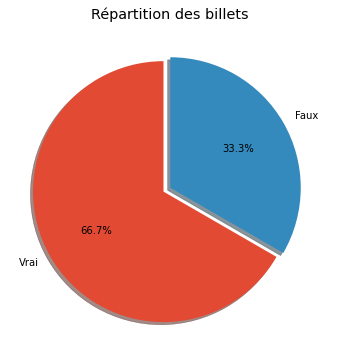

In [17]:
# Création de la variable 'Noms'
labels = 'Vrai', 'Faux'

# Taille
sizes = tableau['freq']

# Division entre la part dominante et le reste
explode = (0.06, 0) 

# Création 'camembert'
fig1, ax1 = plt.subplots(figsize = (12, 6))
ax1.pie(sizes, explode = explode, labels = labels, autopct= '%1.1f%%', shadow = True, normalize = False, startangle = 90)

plt.title("Répartition des billets")

plt.show()

### HISTOGRAMME

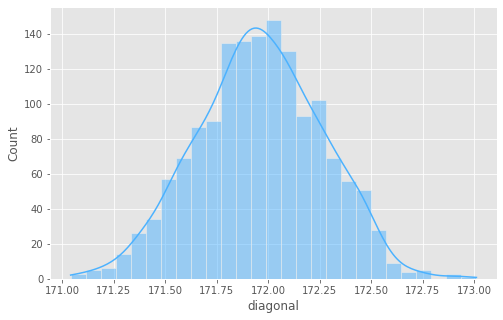

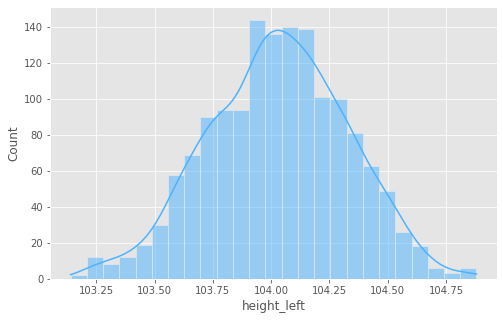

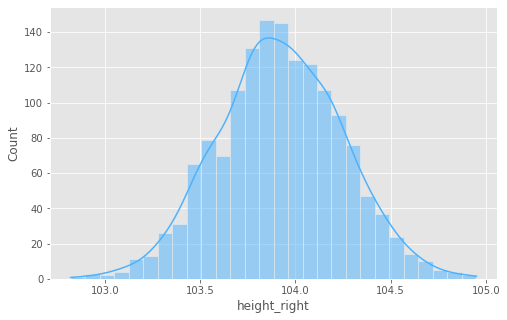

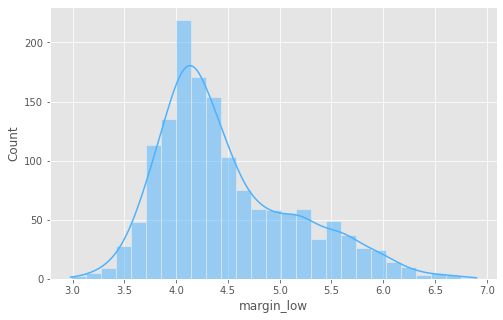

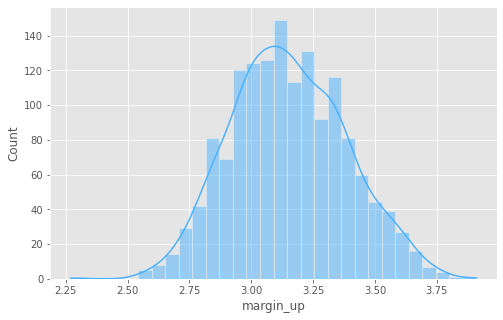

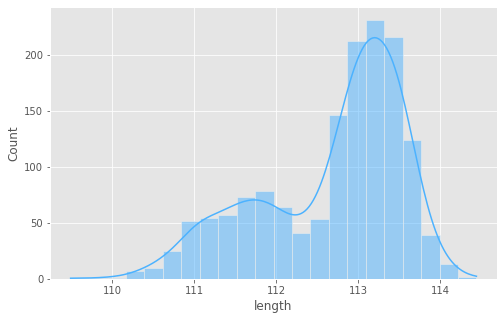

In [18]:
for column in Total_Billet[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']] :
    plt.figure(figsize = (8,5))
    sns.histplot(x=column, data=Total_Billet, kde=True, color='#4cb2ff')
    plt.xlabel(column)

### ANALYSE BIVARIEE

In [19]:
Total_Billet.groupby('is_genuine').describe().T

is_genuine               False        True 
diagonal     count  500.000000  1000.000000
             mean   171.901160   171.987080
             std      0.306861     0.300441
             min    171.040000   171.040000
             25%    171.690000   171.790000
             50%    171.910000   171.990000
             75%    172.092500   172.200000
             max    173.010000   172.920000
height_left  count  500.000000  1000.000000
             mean   104.190340   103.949130
             std      0.223758     0.300231
             min    103.510000   103.140000
             25%    104.040000   103.740000
             50%    104.180000   103.950000
             75%    104.332500   104.140000
             max    104.880000   104.860000
height_right count  500.000000  1000.000000
             mean   104.143620   103.808650
             std      0.270878     0.291570
             min    103.430000   102.820000
             25%    103.950000   103.610000
             50%    104.160000   103.810000
             75%    104.320000   104.000000
             max    104.950000   104.950000
margin_low   count  500.000000  1000.000000
             mean     5.216220     4.116185
             std      0.549114     0.314554
             min      3.820000     2.980000
             25%      4.840000     3.910000
             50%      5.195000     4.112397
             75%      5.590000     4.330000
             max      6.900000     5.040000
margin_up    count  500.000000  1000.000000
             mean     3.350160     3.052130
             std      0.180498     0.186340
             min      2.920000     2.270000
             25%      3.220000     2.930000
             50%      3.350000     3.050000
             75%      3.472500     3.180000
             max      3.910000     3.740000
length       count  500.000000  1000.000000
             mean   111.630640   113.202430
             std      0.615543     0.359552
             min    109.490000   111.760000
             25%    111.200000   112.950000
             50%    111.630000   113.205000
             75%    112.030000   113.460000
             max    113.850000   114.440000

### BOXPLOTS

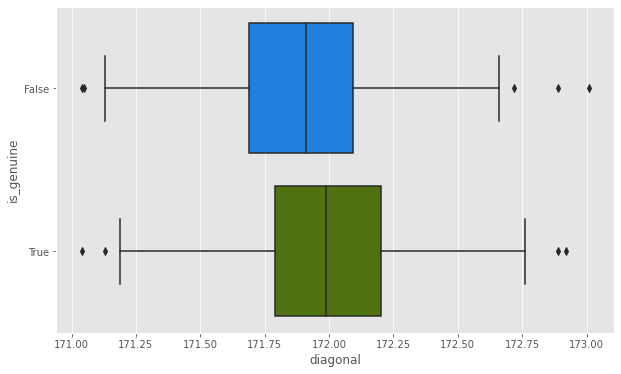

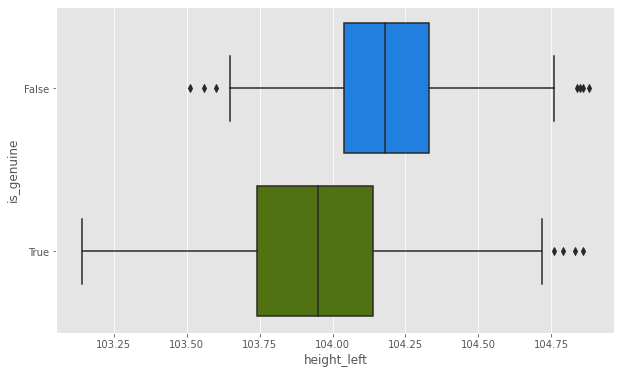

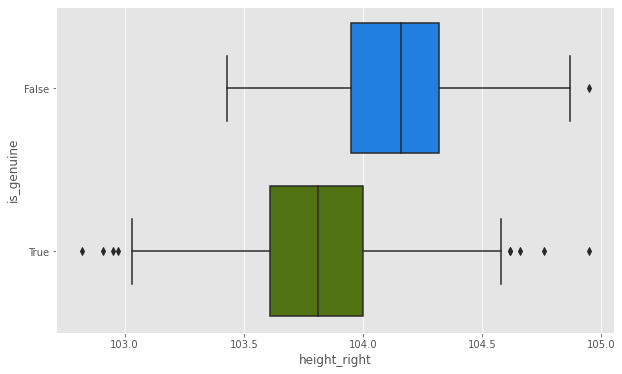

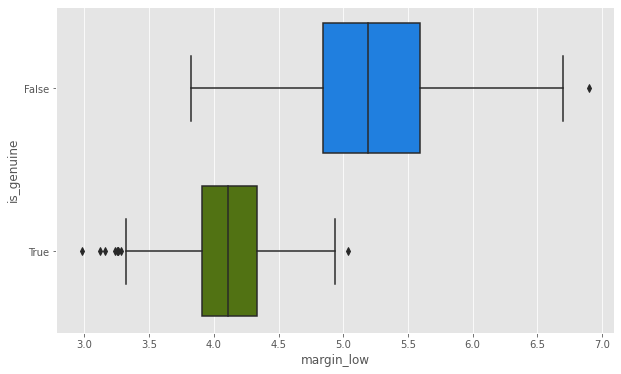

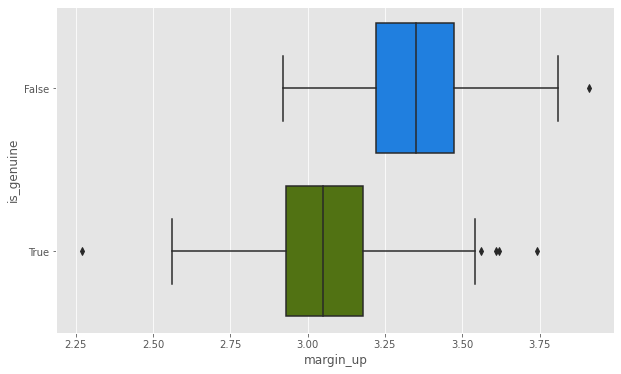

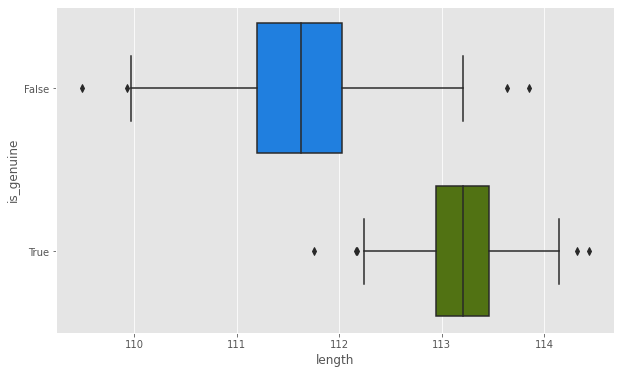

In [20]:
for column in Total_Billet[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']] : 
        plt.figure(figsize = (10,6))
        sns.boxplot( x=column, y='is_genuine', data=Total_Billet, orient='h', palette=('#007FFF', '#568203'))
plt.show()

- On constate quelques outliers dans nos différents graphiques.

### PAIRPLOTS

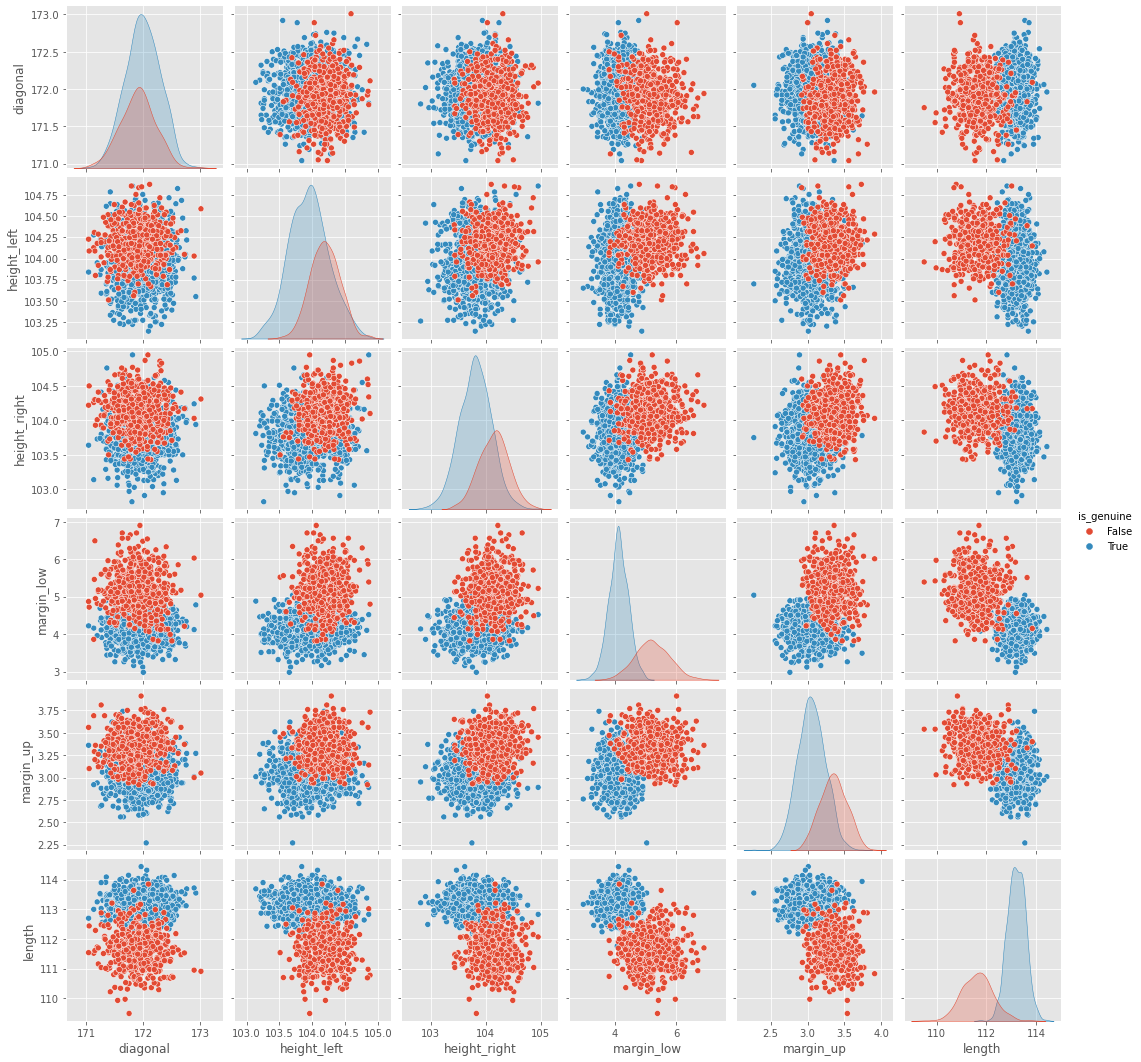

In [21]:
sns.pairplot(Total_Billet, hue="is_genuine")
plt.show()

- Cet graphique permet de différencier les vrais billets des faux billets via les caractéristiques telles que : Length, Margin_low

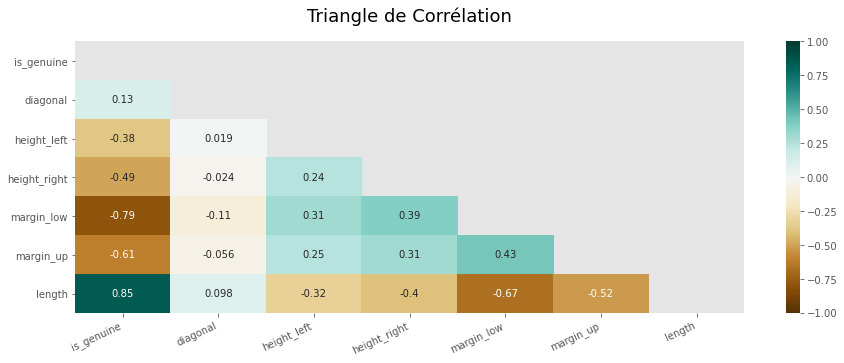

In [22]:
heatmap_corr(Total_Billet)

L'analyse des corrélations montre une correlation negative entre les variables is_genuine et margin_low.<br>
On constate aussi une corrélation positive entre is_genuine et Length.

# Apprentissage non supervisé

### - K-MEANS

In [23]:
#Préparation des données pour le clustering K-Means et transformation en array Numpy
X = Total_Billet.values

#Centrage / réduction des données
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

Pour évaluer un clustering, on peut calculer son <u>COEFFICIENT DE SILHOUETTE</u>.<br>Le coefficient de silhouette est une mesure de qualité d'une partition d'un ensemble de données en classification automatique.

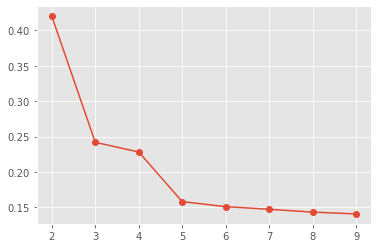

In [24]:
#Créons une liste pour stocker les coefficients

from sklearn import cluster, metrics

silhouettes = [] 

#Boucle de 1 à 10 (clusters) afin de tester les possibilités
for k in range(2, 10): 
    #Modèle pour chaque k
    cls = cluster.KMeans(n_clusters=k)  
    cls.fit(X_scaled)
    
    #Stocker les coefficients de Silhouette
    silh = metrics.silhouette_score(X_scaled, cls.labels_)
    silhouettes.append(silh)

#Pour chaque Cluster, affichage des valeurs de coefficient de silhouette
plt.plot(range(2, 10), silhouettes, marker='o')
plt.show()

La métrique silhouette expose un K = 2

Vérifions la justification de la composition K

In [25]:
X = Total_Billet[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']]
y = Total_Billet['is_genuine']
#centrer et réduire
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)
#clustering k-means
kmeans = KMeans(n_clusters=2, random_state=0)
kmeans.fit(X_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=0, tol=0.0001, verbose=0)

## Analyse en Composante Principale (ACP)

ACP permet d'étudier :<br>
- La variabilité entre les individus
- Les liaisons entre les variables
<br>L'ACP permettra une visualisation des clusters pays sur le 1er plan factoriel (ou plus). Ce sera plus facile de pouvoir appréhender le "comportement" des différents groupes.

In [26]:
# Colonnes selectionnées
#df = df.set_index('Pays')
df_pca = Total_Billet[['diagonal', 'height_left', 'height_right', 'margin_low', 'margin_up', 'length']] 

#Preparation des données
X = df_pca.values
names = Total_Billet.index 
features = df_pca.columns

#Centrer et reduire
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

#Nombre de composantes à calculer
n_comp = 6

# Composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

PCA(copy=True, iterated_power='auto', n_components=6, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

## EBOULIS DES VALEURS PROPRES

C'est un diagramme qui décrit le pourcentage d'inertie totale associé à chaque axe

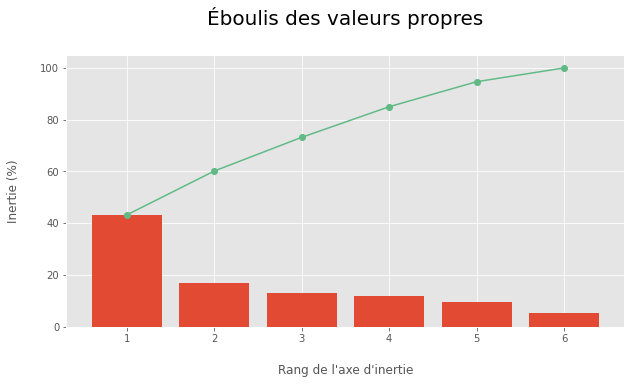

In [27]:
display_scree_plot(pca)

In [28]:
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.cumsum())

[0.43204935 0.16957137 0.13019944 0.11825183 0.09666912 0.0532589 ]
[0.43204935 0.60162072 0.73182015 0.85007198 0.9467411  1.        ]


La projection du nuage des individus sur le premier plan factoriel ne représente que 60 % de l’inertie totale.<br>
Seulement 4 composantes principales pourra expliquée plus 85% de la variance.

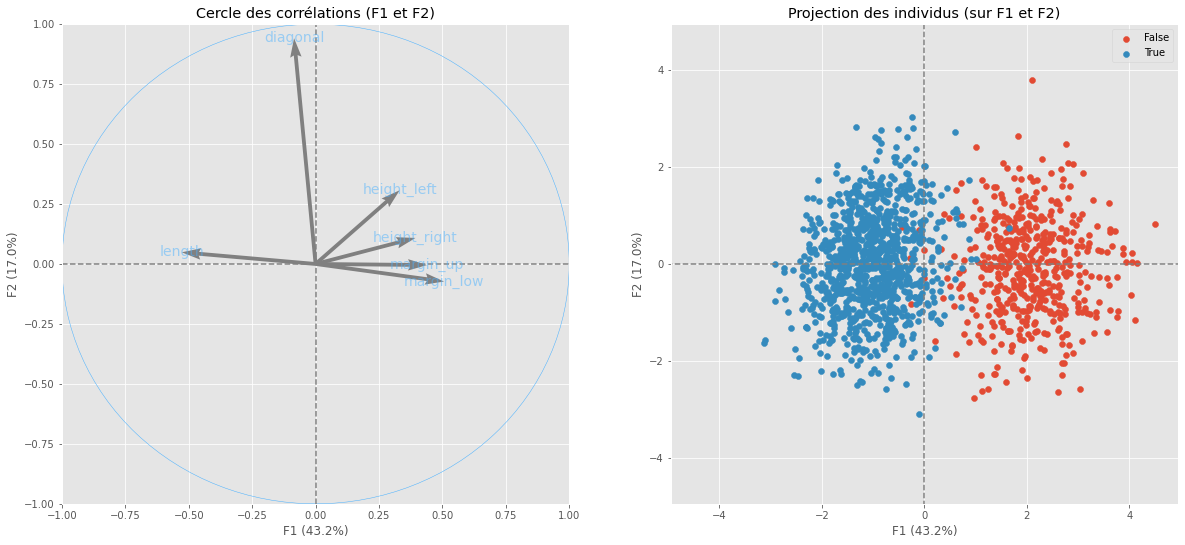

In [29]:
#Cercle des corrélations 
pcs = pca.components_

#projection
X_projected = pca.transform(X_scaled)

#figure
plt.figure(figsize=(20,30))
    
plt.subplot(3, 2, 1)
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

plt.subplot(3, 2, 2)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var =Total_Billet['is_genuine'])

plt.savefig('Cercle des corrélations et projection des individus.jpg', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()

L'axe F1 explique près de 43% de la variances de toutes nos variables excepté la variable 'diagonal' alors que cette dernière est très bien représenter presque 100% sur l'axe F2 avec une explication de la variance de 17%.F1 représente la longueur, hauteur ainsi que la marge du billet et l'axe F2 représente la longueur de la diagonale.
<br><br>
On distingue le nuage des billets valides du nuage des faux billets sur le plan factoriel selon F1 et F2. Ces deux nuages de points se distinguent notamment selon F1 (selon l'axe des abscisses) mais très peu selon F2 (selon l'axe des ordonnées).Les faux billets présentent généralement une plus grande épaisseur, une plus faible longueur, et une image plus centrée sur la face du billet. La longueur de la diagonale semble être globalement similaire d'un vrai à un faux billet.

Il y'a 2 groupes qui se dégagent à partir de la projection des individus sur le 1er plan factoriel

In [30]:
#clusters
n_clust = 2

# Vérification des données
Xn = df_pca.values

# Centrer et Réduire
std_scale = preprocessing.StandardScaler().fit(Xn)
Xn_scaled = std_scale.transform(Xn)

# Clustering par K-means nombres de centroïdes à générer
km = KMeans(n_clusters = n_clust)
#Positionnement de nos centroïdes
km.fit(Xn_scaled)


KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=2, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

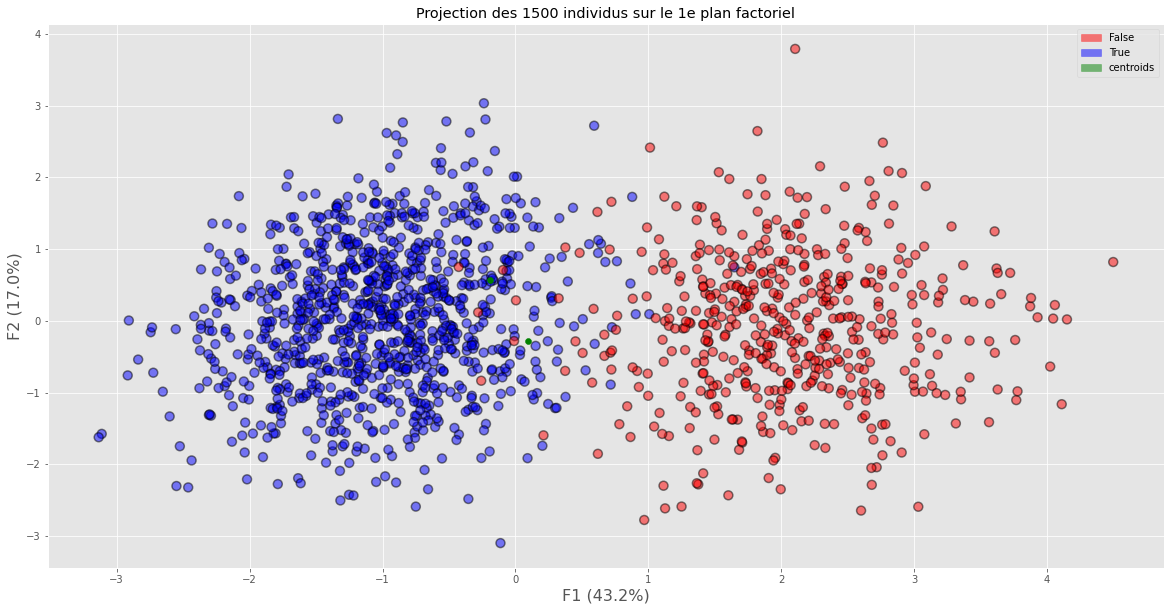

In [31]:
# Nombre de clusters souhaités
n_clust = 2

# préparation des données pour le clustering
Xn = df_pca.values

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(Xn)
Xn_scaled = std_scale.transform(Xn)

# Clustering par K-means
km = KMeans(n_clusters = n_clust) # Nombres de centroïdes à générer
km.fit(Xn_scaled) # Calcul du positionnement de nos centroïdes

# Récupération des clusters attribués à chaque individu
clusters = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA().fit(Xn_scaled)

# Création de notre graphique des individus projetter sur le premier plan factorielle
plt.figure(figsize=(20,10))
X_projected = pca.transform(Xn_scaled) # les coordonnées des points transformés sur les axes principaux (un point par ligne)

colors = ['red', 'blue'] # stockage des couleurs souhaité sur nos individus
plt.scatter(X_projected[:, 0],
            X_projected[:, 1],
            c = Total_Billet['is_genuine'].apply(lambda x: colors[x]),
            alpha = 0.5, edgecolors = 'black', linewidths=1.5, s=80) # Projection des points sur le graphique selon leurs coordonnées

plt.scatter(km.cluster_centers_[:,0], 
            km.cluster_centers_[:,1], 
            c = 'green', 
            label = 'centroids')

# Légendes
# Labels de la nature des billets
lab_0 = mpatches.Patch(color='red', alpha=0.5, label='False')
lab_1 = mpatches.Patch(color='blue', alpha=0.5, label='True')
lab_2 = mpatches.Patch(color='green', alpha=0.5, label='centroids')
plt.legend(handles=[lab_0, lab_1, lab_2])

plt.xlabel('F{} ({}%)'.format(1, round(100*pca.explained_variance_ratio_[0],1)), fontsize = 16) # Calcul des ratios de la variance expliquée sur la variance totale pour l'axe x
plt.ylabel('F{} ({}%)'.format(2, round(100*pca.explained_variance_ratio_[1],1)), fontsize = 16) # Calcul des ratios de la variance expliquée sur la variance totale pour l'axe y
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))

plt.show()

# Centroïds
#coord_centroids = km.cluster_centers_
#print(km.cluster_centers_)

- La projection des individus sur le 1ER permet de constater 2 groupes
- Les clusters sont assez bien distingués

In [32]:
# Centroïds de nos clusters
centroids = km.cluster_centers_
pd.DataFrame(centroids, columns = df_pca.columns)

,diagonal,height_left,height_right,margin_low,margin_up,length
0,-0.194323,0.570713,0.713365,1.120131,0.864176,-1.200833
1,0.096000,-0.281946,-0.352419,-0.553371,-0.426924,0.593240


## clusters selon notre KMeans dans notre dataframe

In [33]:
#'fit_predict' calcule l'appartenance d'un individu à un cluster
df_clusters = pd.DataFrame(km.fit_predict(X), columns = ['clusters']) 
df_clusters = pd.concat([df_clusters, Total_Billet], axis=1)
df_clusters.to_csv('df_clusters') # Enregistrement df_clusters
df_clusters

,clusters,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,0,True,171.46,103.36,103.66,3.77,2.99,113.09
2,0,True,172.69,104.48,103.50,4.40,2.94,113.16
3,0,True,171.36,103.91,103.94,3.62,3.01,113.51
4,0,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...,...
1495,1,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,1,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,1,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,1,False,172.06,104.28,104.06,5.17,3.46,112.25


In [34]:
# Tableau d'association Clusters/nature billets
Assos = pd.crosstab(km.labels_, df_clusters['is_genuine'])
Assos.index = ['Cluster 0 - Faux', 'Cluster 1 - Vrai']
Assos

is_genuine,False,True
Cluster 0 - Faux,19,998
Cluster 1 - Vrai,481,2


L'analyse du KMeans fonctionne trés bien, les 1500 billets ont été analysé et séparés dans nos clusters.

# APPRENTISSAGE SUPERVISE

## REGRESSION LOGISTIQUE

L'objectif de la <u>REGRESSION LOGISTIQUE</u> est de modéliser, de classifier, une variable binaire prenant ses valeurs dans {0,1} en fonction de variables explicatives quantitatives (et potentiellement qualitatives). La régression logistique est une méthode de classification (supervisée).

In [35]:
#Préparation des données
X = df_clusters.copy()
# Nous allons enlever la variable 'is_genuine' car c'est une variable qualitative
X = X.iloc[:, 2:]
# Stocker des valeurs de la variable 'clusters'
y = df_clusters.iloc[:, 1]

In [36]:
from sklearn.model_selection import train_test_split

# Division entre les données : 
# - données d'entrainement X_train, y_train,
# - données test X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

print('Train set : ', X_train.shape)
print('Test set : ', X_test.shape)

Train set :  (1200, 6)
Test set :  (300, 6)


j'ai divisé mes données en 80 / 20 comme il est recommandé la plupart du temps

In [37]:
# Modèle de régression logistique
from sklearn.linear_model import LogisticRegression

# Entrainons nos données
lr = LogisticRegression()

 # Entrainement des valeurs d'entrainement
lr.fit(X_train, y_train)

 # résultat obtenu
lr.score(X_train, y_train)

0.99

J'obtiens un coefficient de determination de 0.9933, cela est très bien pour mon modèle d'entrainement.

## Evaluons notre modèle avec les valeurs test

In [38]:
from sklearn.metrics import confusion_matrix

# Prédire les valeurs de notre variable de test
y_predict = lr.predict(X_test)

# Prédiction dans une matrice de confusion
conf_matrix = confusion_matrix(y_test, y_predict)
print(conf_matrix)

[[ 91   2]
 [  0 207]]


# Matrice de confusion

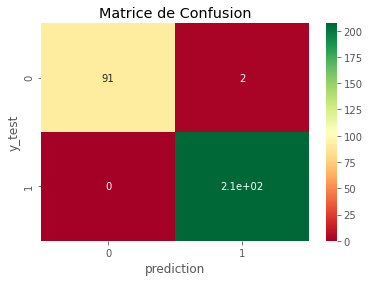

In [39]:
sns.heatmap(conf_matrix, cmap = 'RdYlGn', annot = True)

plt.title('Matrice de Confusion')
plt.xlabel('prediction')
plt.ylabel('y_test')
 
plt.show()

## Test de l’algorithme en direct avec un jeu de données

In [41]:
# importation et chargement de l'échantillon
df_Test = pd.read_csv('billets_production.csv')

# Copie de l'échantillon
df_Test_copy = df_Test.copy()
df_Test_copy

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [52]:
# filtre sur les données
df_Test_copy = df_Test_copy.iloc[:, :-1]

# modéle de prédiction
proba = lr.predict_proba(df_Test_copy.values)[:, 1]

# Transformation de notre variable
proba = pd.Series(proba.round(2), name = 'predict_proba')

# Ajout de cette nouvelle variable à notre dataframe
df_Test_copy = pd.concat([df_Test_copy, proba], axis = 1)

In [55]:
# Boucle afin de rajouter une nouvelle colonne 'attribut' pour prevoir si le billet est vrai ou faux avec 'predict_proba'
attribut = []
for i in df_Test_copy['predict_proba'] >= .5:
    if i is True :
        attribut.append('Vrai billet')
    else :
        attribut.append('Faux billet')
    
df_Test_copy['attribut'] = attribut
df_Test_copy

,diagonal,height_left,height_right,margin_low,margin_up,length,predict_proba,attribut
0,171.76,104.01,103.54,5.21,3.30,111.42,0.00,Faux billet
1,171.87,104.17,104.13,6.00,3.31,112.09,0.00,Faux billet
2,172.00,104.58,104.29,4.99,3.39,111.57,0.00,Faux billet
3,172.49,104.55,104.34,4.44,3.03,113.20,0.91,Vrai billet
4,171.65,103.63,103.56,3.77,3.16,113.33,1.00,Vrai billet


## APPLICATION FINALE
<br>
- TEST DE L'ALGO AVEC UN FICHIER DU MÊME TYPE

In [56]:
# importation et chargement du fichier test pour l'Algo
df_Ago = pd.read_csv('attente fichier.csv')
# Stockage de la variable 'id' afin de l'utiliser plus tard
df_Ago = df_Ago['id']

In [57]:
#Importation de notre df test
df_clusters = pd.read_csv('df_clusters')

#Préparons nos données
X = df_clusters.copy()

 # filtre sur la variable qualitatif
X = X.iloc[:, 3:]
y = df_clusters.iloc[:, 2] # Stockage des valeurs de la variable 'clusters' dans une nouvelle variable

# Division entre les données : 
# - données d'entrainement X_train, y_train,
# - données test X_test, y_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Entrainons nos données
lr = LogisticRegression()
lr.fit(X_train, y_train)
lr.score(X_train, y_train)

#Prédiction de la variable test: les valeurs
y_predict = lr.predict(X_test)

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_predict)

In [1]:
# Préparation des données
df = pd.read_csv('attente fichier.csv')
Xi = df.copy()
Xi = Xi.iloc[:, :-1]

# Centrage et réduction de nos données, Standardisations de nos valeurs
std_scale = preprocessing.StandardScaler().fit(Xi)
X_scaled = std_scale.transform(Xi)

# Utilisation du modéle de prédiction
proba = lr.predict_proba(X_scaled)[:, 1]

# Transformation de notre variable en 'séries' pour pouvoir l'ajouter à notre dataframe
proba = pd.Series(proba.round(3), name = 'predict_proba')

# Ajout de cette nouvelle variable à notre dataframe
df_proba = pd.concat([Xi, proba], axis = 1)

# Boucle afin de rajouter une nouvelle colonne 'attribut' pour prevoir si le billet est vrai ou faux
attribut = []
for i in df_proba['predict_proba'] >= .5:
    if i is True :
        attribut.append('Vrai billet')
    else :
        attribut.append('Faux billet')
    
df_proba['attribut'] = attribut
df_proba

NameError: name 'pd' is not defined

In [2]:
df_global = pd.concat([df_proba, df_Ago], axis = 1)
df_global

NameError: name 'pd' is not defined